In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    computed_data_dir = "/content/drive/MyDrive/colab/computed-data"

    from google.colab import drive

    drive.mount('/content/drive')
else:
    computed_data_dir = "./computed-data"

import os

try:
    os.makedirs(f"{computed_data_dir}/")
except:
    pass

In [2]:
!pip install binance_historical_data mplfinance stable-baselines3 backtesting tensorboard binance ta scikit-learn line_profiler

In [3]:
if IN_COLAB:
    !rm -rf ./python-price-predict-experiment
    !git clone https://github.com/Klok-e/python-price-predict-experiment.git

    import sys

    sys.path.insert(0, 'python-price-predict-experiment')

In [4]:
%load_ext line_profiler

In [5]:
from utils.util import download_and_process_data_if_available, split_tickers_train_test, create_synthetic_price_data, \
    create_random_walk_price_data, __download_data, __full_handle_tickers, generate_labels_for_supervised
import numpy as np
import pandas as pd

np.random.seed(42)

# %lprun -f generate_labels_for_supervised download_and_process_data_if_available(f"{computed_data_dir}/dataset", reload=True)

df_tickers = download_and_process_data_if_available(f"{computed_data_dir}/dataset"
                                                    , reload=False
                                                    , need_download=True
                                                    , sl=0.4
                                                    , tp=0.4
                                                    #, tickers=["SOLUSDT"]
                                                    )

# df_tickers = create_synthetic_price_data()
# df_tickers = create_random_walk_price_data()

Loading data from cache


In [6]:
df_tickers[0][0].describe()

,Open,High,Low,Close,SMA_256,SMA_512,SMA_1024,MACD_diff,RSI,stoch
count,2.299560e+06,2.299560e+06,2.299560e+06,2.299560e+06,2.299560e+06,2.299560e+06,2.299560e+06,2.299560e+06,2.299560e+06,2.299560e+06
mean,-1.626199e-03,-1.257513e-02,1.015261e-02,-1.322063e-03,1.050905e-02,1.940495e-02,2.598400e-02,1.029865e-04,6.631842e-03,3.389314e-03
std,8.714349e-01,9.239493e-01,9.259996e-01,8.661979e-01,9.131627e-01,8.081456e-01,6.909892e-01,9.128944e-01,7.419653e-01,5.560890e-01
min,-2.627120e+00,-3.017953e+00,-2.986049e+00,-2.569392e+00,-2.871821e+00,-1.988433e+00,-1.356854e+00,-3.094016e+00,-3.125512e+00,-8.755539e-01
25%,-5.029429e-01,-5.247762e-01,-4.786575e-01,-5.025049e-01,-4.947576e-01,-4.828880e-01,-4.733391e-01,-5.003478e-01,-4.962094e-01,-4.948696e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.405355e-18,1.678250e-19,2.244175e-16,0.000000e+00
75%,4.970571e-01,4.752238e-01,5.213425e-01,4.974951e-01,5.052424e-01,5.171120e-01,5.266609e-01,4.996522e-01,5.037906e-01,5.051304e-01
max,2.627120e+00,3.017953e+00,2.986049e+00,2.569392e+00,2.889193e+00,2.025491e+00,1.416327e+00,3.097589e+00,3.136959e+00,8.755539e-01


In [7]:
df_tickers[0][1].describe()

,Open,High,Low,Close,SMA_256,SMA_512,SMA_1024,MACD_diff,RSI,stoch
count,2.299561e+06,2.299561e+06,2.299561e+06,2.299561e+06,2.299561e+06,2.299561e+06,2.299561e+06,2.299561e+06,2.299561e+06,2.299561e+06
mean,4.551263e+00,4.556399e+00,4.546113e+00,4.551269e+00,6.330264e-04,4.364382e-04,-2.706492e-03,-5.439317e-04,4.998655e+01,5.019356e+01
std,3.547103e+00,3.552047e+00,3.542145e+00,3.547109e+00,3.170147e-01,4.026709e-01,4.983371e-01,2.948814e-01,1.174592e+01,3.175641e+01
min,5.250000e-01,5.256000e-01,5.246000e-01,5.248000e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,4.021437e-01,0.000000e+00
25%,1.949600e+00,1.951000e+00,1.948000e+00,1.949500e+00,-1.747761e-01,-2.498387e-01,-3.628156e-01,-1.621988e-01,4.202616e+01,2.173963e+01
50%,3.490000e+00,3.494000e+00,3.486000e+00,3.490000e+00,-3.015221e-03,-9.232628e-03,-2.144573e-02,-5.770587e-04,4.988156e+01,5.000000e+01
75%,5.828000e+00,5.835000e+00,5.821700e+00,5.828000e+00,1.723852e-01,2.484264e-01,3.583784e-01,1.608195e-01,5.785699e+01,7.884633e+01
max,2.044600e+01,2.059700e+01,2.040500e+01,2.044000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.954219e+01,1.000000e+02


In [8]:
df_tickers[0][2].describe()

,Label
count,2.299560e+06
mean,4.926877e-01
std,4.999466e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [9]:

df_tickers_train, df_tickers_test = split_tickers_train_test(
    df_tickers, 30)
del df_tickers

In [10]:
%load_ext tensorboard
%tensorboard --logdir "$computed_data_dir/tensorboard"

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/home/dima/Desktop/python-price-predict-experiment/.venv/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/home/dima/Desktop/python-price-predict-experiment/.venv/lib/python3.13/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/home/dima/Desktop/python-price-predict-experiment/.venv/lib/python3.13/site-packages/tensorboard/default.py", line 40, in <module>
    from tensorboard.plugins.image import images_plugin
  File "/home/dima/Desktop/python-price-predict-experiment/.venv/lib/python3.13/site-packages/tensorboard/plugins/image/images_plugin.py", line 18, in <module>
    import imghdr
ModuleNotFoundError: No module named 'imghdr'

In [11]:
from models import PricePredictorModel, LSTMPricePredictorModel
from train_supervised import train_supervised_model

window_size = 128
model_type = PricePredictorModel
model_kwargs = {"linear_arch": [1024, 512, 512, 512, 512, 256, 256, 256, 128, 64, 32], }
model_name = f"linear{model_kwargs['linear_arch']}_ws{window_size}"

# model_type = LSTMPricePredictorModel
# model_kwargs = {"pre_lstm_arch": [16], "post_lstm_arch": [512, 256, 64, 32], "hidden_size": 256,
                # "num_layers": 2}
# model_name = (f"pre[{model_kwargs['pre_lstm_arch']}]"
#               f"_post[{model_kwargs['post_lstm_arch']}]"
#               f"_hs({model_kwargs['hidden_size']})"
#               f"_lstm-layers({model_kwargs['num_layers']})")
#               f"ws{window_size}")

In [12]:
# train_supervised_model(model_type,
#                        model_kwargs,
#                        df_tickers_train,
#                        df_tickers_test,
#                        window_size,
#                        computed_data_dir,
#                        model_name,
#                        learning_rate=0.001,
#                        epochs=100,
#                        batch_size=1024,
#                        save_model=True,
#                        log_interval=100)

In [13]:
from backtest import create_backtest_model_with_data, create_buy_and_hold_strategy
from model_load_backtest import run_backtest_on_all_tickers, print_metrics
from stable_baselines3 import PPO
from utils.util import get_name_max_timesteps
import re
import os
import torch

!rm -rf "$computed_data_dir/backtest-results/"

filenames = next(os.walk(f"{computed_data_dir}/supervised_model/"), (None, [], None))[2]

for i, filename in enumerate(sorted(filenames)):
    print(filename)

    window_size = int(re.match(".*?ws(\\d+).*", filename).group(1))
    print(window_size)

    model = model_type(feature_size=df_tickers_train[0][0].shape[1], window_size=window_size, **model_kwargs)
    model.load_state_dict(torch.load(f"{computed_data_dir}/supervised_model/{filename}", weights_only=True))

    metrics = run_backtest_on_all_tickers(
        df_tickers_test,
        f"Model {dir}",
        window_size,
        lambda df, scaler, model_in_observations, start, end: create_backtest_model_with_data(
            model, df, scaler, start, end, model_in_observations, print_actions=True, confidence_threshold=0.9
        ),
        computed_data_dir,
    )
    print_metrics(*metrics)

metrics = run_backtest_on_all_tickers(
    df_tickers_test,
    "Buy and Hold",
    64,
    lambda df, scaler, model_in_observations, start, end: create_buy_and_hold_strategy(
        df, start, end
    ),
    computed_data_dir,
)
print_metrics(*metrics)

/home/dima/Desktop/python-price-predict-experiment/.venv/lib/python3.13/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

linear[1024, 512, 512, 512, 512, 256, 256, 256, 128, 64, 32]_ws128.pth
128
backtest for NEARUSDT started


Backtest.run:   0%|          | 0/9057 [00:00<?, ?bar/s]

[2025-04-25T12:19:00.000000000] bought at 2.61899995803833
[2025-04-25T12:24:00.000000000] sold at 2.6050000190734863; gain -0.007332850139536617; equity 994040.3125
[2025-04-25T12:38:00.000000000] bought at 2.6059999465942383
[2025-04-25T12:44:00.000000000] sold at 2.619999885559082; gain 0.0033634589939985516; equity 995008.125
[2025-04-25T12:57:00.000000000] bought at 2.5980000495910645
[2025-04-25T13:29:00.000000000] sold at 2.5840001106262207; gain -0.007375972279803663; equity 994749.0
[2025-04-25T13:30:00.000000000] bought at 2.5920000076293945
[2025-04-25T13:32:00.000000000] sold at 2.572999954223633; gain -0.009313623604977568; equity 980464.3125
[2025-04-25T13:33:00.000000000] bought at 2.5810000896453857
[2025-04-25T13:35:00.000000000] sold at 2.5940001010894775; gain 0.0030287461401723808; equity 978409.0625
[2025-04-25T13:36:00.000000000] bought at 2.5980000495910645
[2025-04-25T14:06:00.000000000] sold at 2.611999988555908; gain 0.003379968283799785; equity 977486.0625
[2

Backtest.run:   0%|          | 0/9057 [00:00<?, ?bar/s]

[2025-04-25T12:28:00.000000000] bought at 154.3000030517578
[2025-04-25T12:53:00.000000000] sold at 153.41000366210938; gain -0.007754457937874781; equity 993175.4375
[2025-04-25T12:54:00.000000000] bought at 153.4499969482422
[2025-04-25T13:32:00.000000000] sold at 152.5500030517578; gain -0.00785134657111365; equity 983024.8125
[2025-04-25T13:35:00.000000000] bought at 153.49000549316406
[2025-04-25T14:05:00.000000000] sold at 154.2899932861328; gain 0.00320357065941497; equity 977997.375
[2025-04-25T14:08:00.000000000] bought at 154.61000061035156
[2025-04-25T14:14:00.000000000] sold at 155.7100067138672; gain 0.005102497871276808; equity 978857.3125
[2025-04-25T14:19:00.000000000] bought at 155.14999389648438
[2025-04-25T14:22:00.000000000] sold at 154.1999969482422; gain -0.008108855299575796; equity 972472.4375
[2025-04-25T14:23:00.000000000] bought at 154.4600067138672
[2025-04-25T14:46:00.000000000] sold at 155.4600067138672; gain 0.004463230389814576; equity 973087.9375
[2025-

Backtest.run:   0%|          | 0/9057 [00:00<?, ?bar/s]

[2025-04-25T12:14:00.000000000] bought at 1796.6500244140625
[2025-04-25T12:24:00.000000000] sold at 1788.4100341796875; gain -0.0065751464644680105; equity 994419.625
[2025-04-25T12:25:00.000000000] bought at 1786.699951171875
[2025-04-25T12:53:00.000000000] sold at 1778.010009765625; gain -0.006851966918227893; equity 986576.9375
[2025-04-25T12:54:00.000000000] bought at 1773.1400146484375
[2025-04-25T13:32:00.000000000] sold at 1761.5; gain -0.00854951952055725; equity 978876.9375
[2025-04-25T13:35:00.000000000] bought at 1771.4300537109375
[2025-04-25T14:10:00.000000000] sold at 1780.18994140625; gain 0.002937211449393812; equity 974285.625
[2025-04-25T14:12:00.000000000] bought at 1783.5999755859375
[2025-04-25T14:22:00.000000000] sold at 1776.2900390625; gain -0.006088230387504901; equity 964566.3125
[2025-04-25T14:23:00.000000000] bought at 1776.449951171875
[2025-04-25T14:43:00.000000000] sold at 1784.1700439453125; gain 0.0023391131611214815; equity 964791.9375
[2025-04-25T14:

Backtest.run:   0%|          | 0/9057 [00:00<?, ?bar/s]

[2025-04-25T12:21:00.000000000] bought at 606.9099731445312
[2025-04-25T12:53:00.000000000] sold at 604.4500122070312; gain -0.00604315867570767; equity 994968.3125
[2025-04-25T13:02:00.000000000] bought at 604.9299926757812
[2025-04-25T13:32:00.000000000] sold at 602.239990234375; gain -0.006435916870231577; equity 985871.4375
[2025-04-25T14:24:00.000000000] bought at 604.3300170898438
[2025-04-25T14:46:00.000000000] sold at 607.1400146484375; gain 0.002642481013849649; equity 983073.1875
[2025-04-25T14:47:00.000000000] bought at 607.0700073242188
[2025-04-25T16:06:00.000000000] sold at 604.5999755859375; gain -0.006058648348821481; equity 975278.9375
[2025-04-25T16:43:00.000000000] bought at 605.0499877929688
[2025-04-25T17:54:00.000000000] sold at 602.5499877929688; gain -0.006121636483320922; equity 966652.8125
[2025-04-25T18:34:00.000000000] bought at 603.9600219726562
[2025-04-25T21:23:00.000000000] sold at 601.510009765625; gain -0.006046477044016184; equity 956641.75
[2025-04-2

Backtest.run:   0%|          | 0/9057 [00:00<?, ?bar/s]

backtest for NEARUSDT finished; time taken: 0.04565095901489258
backtest for SOLUSDT started


Backtest.run:   0%|          | 0/9057 [00:00<?, ?bar/s]

backtest for SOLUSDT finished; time taken: 0.04573392868041992
backtest for ETHUSDT started


Backtest.run:   0%|          | 0/9057 [00:00<?, ?bar/s]

backtest for ETHUSDT finished; time taken: 0.05158638954162598
backtest for BNBUSDT started


Backtest.run:   0%|          | 0/9057 [00:00<?, ?bar/s]

backtest for BNBUSDT finished; time taken: 0.04628276824951172

Buy and Hold metrics:
cumulative_return=-0.0237, max_earning_rate=3.0498, maximum_pullback=0.0047, average_profitability_per_trade=-inf, sharpe_ratio=-0.0038



/home/dima/Desktop/python-price-predict-experiment/utils/trading_metrics.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  return ((P_end - P_0) / P_0) / NT * 100



Model <built-in function dir> metrics:
cumulative_return=-0.4683, max_earning_rate=0.0032, maximum_pullback=0.2000, average_profitability_per_trade=-0.0361, sharpe_ratio=-0.1492


Buy and Hold metrics:
cumulative_return=-0.0237, max_earning_rate=0.0045, maximum_pullback=0.1900, average_profitability_per_trade=-inf, sharpe_ratio=-0.0038



/home/dima/Desktop/python-price-predict-experiment/utils/trading_metrics.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  return ((P_end - P_0) / P_0) / NT * 100


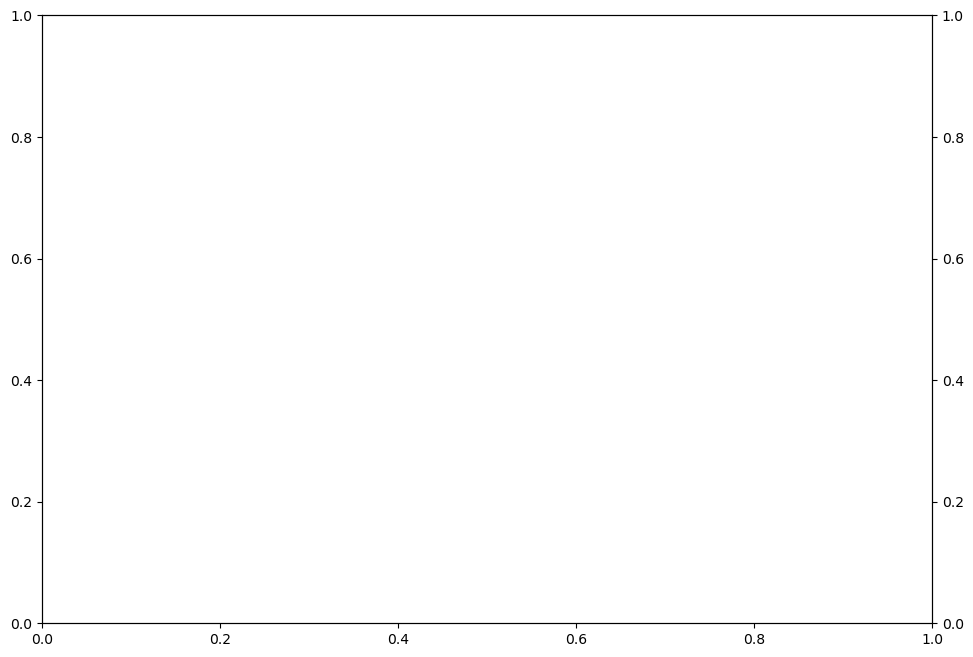

In [14]:

from utils.util import load_pickle
import os
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from utils.trading_metrics import calculate_metrics
import re
import pandas as pd


def plot_equity(model_name, model_equities, ax1, ax2, plot_hist):
    match = re.search("ws(\\d+)", model_name)
    in_obs = int(match.group(1)) if match else 64
    skip_steps = 1024 + in_obs

    sum_equity = None
    buy_trades = []
    sell_trades = []
    for item in model_equities:
        if sum_equity is None:
            sum_equity = item[2]["Equity"].iloc[skip_steps:].copy()
        else:
            sum_equity += item[2]["Equity"].iloc[skip_steps:]

        if len(item[1]) > 0:
            buy_trades.append(item[1]["EntryTime"])
            sell_trades.append(item[1]["ExitTime"])

    if len(buy_trades) > 0:
        buy_trades = pd.concat(buy_trades)
        sell_trades = pd.concat(sell_trades)

        combined_trades = pd.DataFrame({
            "Buy trades": buy_trades,
            "Sell trades": sell_trades
        })

    start_cash = 1_000_000
    tickers_count = 5
    trades_count = sum(map(lambda x: len(x[1]), model_equities))
    metrics = calculate_metrics(sum_equity, trades_count, start_cash * tickers_count)

    sum_equity = sum_equity.rolling(window=256).mean()[256:]

    y = (sum_equity - start_cash * tickers_count) / (start_cash * tickers_count)

    # Plot line on the primary axis
    ax1.plot(y, markevery=1024, label=model_name)

    # Plot histogram on the secondary axis
    if plot_hist and len(buy_trades) > 0:
        ax2.hist(combined_trades, bins=32, alpha=0.5, label=["Buy trades", "Sell trades"], color=['green', 'red'])

    print()
    print(f"{model_name} metrics:")
    print(f"cumulative_return={metrics[0]:.4f}, "
          f"max_earning_rate={metrics[1]:.4f}, "
          f"maximum_pullback={metrics[2]:.4f}, "
          f"average_profitability_per_trade={metrics[3]:.4f}, "
          f"sharpe_ratio={metrics[4]:.4f}")
    print()


filenames = next(os.walk(f"{computed_data_dir}/backtest-results/"), (None, None, []))[2]  # [] if no file
results = {}
for filename in filenames:
    (trades, equity_curve) = load_pickle(f"{computed_data_dir}/backtest-results/{filename}")
    parts = filename.split("_")
    model_name = "_".join(parts[:-1])  # Get all parts except the last one as the model name
    coin = parts[-1].split('.')[0]  # Get the last part as the coin, and remove file extension

    if model_name not in results:
        results[model_name] = []
    results[model_name].append((coin, trades, equity_curve, filename))

buy_hold = "Buy and Hold"
buy_hold_res = results.pop(buy_hold)

plt.figure(figsize=(10, 7))

ax1 = plt.gca()
ax2 = ax1.twinx()

for i, model in enumerate(sorted(list(results.keys()))):
    plot_equity(model, results[model], ax1, ax2, True)

    plot_equity(buy_hold, buy_hold_res, ax1, ax2, False)

    ax2.set_ylim([0, max(ax2.get_ylim()[1], ax1.get_ylim()[1])])

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()

    # plt.show()

    try:
        os.makedirs(f"{computed_data_dir}/pics")
    except:
        pass
    plt.savefig(f"{computed_data_dir}/pics/figure{i}.png")
    ax1.cla()
    ax2.cla()